In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
def load_data(filepath):
    """
    Load the student data from a CSV file.
    
    Parameters:
        filepath (str): The path to the CSV file.
    
    Returns:
        pd.DataFrame: Loaded data.
    """
    data = pd.read_csv(filepath)
    return data

# Preprocess the data
def preprocess_data(df):
    """
    Preprocess the data by dropping unnecessary columns and encoding categorical variables.
    
    Parameters:
        df (pd.DataFrame): The original dataframe.
    
    Returns:
        pd.DataFrame: Preprocessed dataframe.
    """
    # Drop 'G1' and 'G2' columns
    df = df.drop(['G1', 'G2'], axis=1)
    
    # Identify numerical and categorical columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    # Exclude the target and treatment variables
    numeric_cols = [col for col in numeric_cols if col not in ['studytime', 'G3']]
    
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Define transformers for numerical and categorical data
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
    
    # Fit and transform the data
    df_processed = preprocessor.fit_transform(df)
    
    # Get feature names after encoding
    encoded_cols = []
    if numeric_cols:
        encoded_cols += numeric_cols
    if categorical_cols:
        encoded_cols += preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols).tolist()
    
    # Convert to DataFrame
    df_processed = pd.DataFrame(df_processed, columns=encoded_cols)
    
    # Add treatment and outcome variables
    df_processed['studytime'] = df['studytime']
    df_processed['G3'] = df['G3']
    
    return df_processed


In [3]:
# Define treatment (binary) based on 'studytime'
def define_treatment(df, threshold=2.5):
    """
    Define the treatment variable based on 'studytime'.
    
    Parameters:
        df (pd.DataFrame): The preprocessed dataframe.
        threshold (int): The threshold to define treated vs control.
    
    Returns:
        pd.DataFrame: Dataframe with 'treatment' column.
    """
    df['treatment'] = np.where(df['studytime'] > threshold, 1, 0)
    return df

# Calculate propensity scores
def calculate_propensity_scores(df, feature_cols):
    """
    Calculate propensity scores using logistic regression.
    
    Parameters:
        df (pd.DataFrame): The dataframe with treatment and covariates.
        feature_cols (list): List of feature column names.
    
    Returns:
        pd.Series: Propensity scores.
        LogisticRegression: Fitted logistic regression model.
    """
    X = df[feature_cols]
    y = df['treatment']
    
    # Initialize and fit logistic regression
    model = LogisticRegression(max_iter=1000)
    model.fit(X, y)
    
    # Predict propensity scores
    propensity_scores = model.predict_proba(X)[:, 1]
    
    return propensity_scores, model

In [4]:
# Perform nearest neighbor matching
def perform_matching(df, propensity_scores, caliper=0.8):
    """
    Perform nearest neighbor matching based on propensity scores.
    
    Parameters:
        df (pd.DataFrame): The dataframe with treatment, outcome, and propensity scores.
        propensity_scores (pd.Series): The propensity scores.
        caliper (float): The maximum allowable difference in propensity scores.
    
    Returns:
        pd.DataFrame: Matched treated and control units.
    """
    treated = df[df['treatment'] == 1].copy()
    control = df[df['treatment'] == 0].copy()
    
    treated = treated.reset_index(drop=True)
    control = control.reset_index(drop=True)
    
    # Initialize NearestNeighbors
    nn = NearestNeighbors(n_neighbors=1, radius=caliper)
    nn.fit(control[['propensity_score']])
    
    distances, indices = nn.kneighbors(treated[['propensity_score']], return_distance=True)
    # Flatten results
    indices = indices.flatten()
    distances = distances.flatten()
    # print(distances)
    # Apply caliper
    matched_idx = distances <= caliper
    treated_matched = treated[matched_idx]
    control_matched = control.iloc[indices[matched_idx]]

    # Combine
    matched = pd.concat([treated_matched, control_matched], axis=0)
    return matched


In [5]:
# Assess balance
def assess_balance(df, feature_cols, treatment_col='treatment'):
    """
    Assess the balance of covariates between treated and control groups.
    
    Parameters:
        df (pd.DataFrame): The matched dataframe.
        feature_cols (list): List of feature column names.
        treatment_col (str): The treatment column name.
    
    Returns:
        None
    """
    for col in feature_cols:
        plt.figure(figsize=(8,4))
        sns.kdeplot(data=df, x=col, hue=treatment_col, common_norm=False)
        plt.title(f'Balance of {col}')
        plt.show()

# Estimate causal effect
def estimate_effect(matched_df):
    """
    Estimate the Average Treatment Effect on the Treated (ATT).
    
    Parameters:
        matched_df (pd.DataFrame): The matched dataframe.
    
    Returns:
        float: Estimated ATT.
    """
    treated = matched_df[matched_df['treatment'] == 1]['G3']
    control = matched_df[matched_df['treatment'] == 0]['G3']
    att = treated.mean() - control.mean()
    return att

In [6]:
# Visualize propensity score distribution
def visualize_propensity_scores(df, propensity_scores):
    """
    Visualize the distribution of propensity scores for treated and control groups.
    
    Parameters:
        df (pd.DataFrame): The dataframe with treatment.
        propensity_scores (pd.Series): The propensity scores.
    
    Returns:
        None
    """
    plt.figure(figsize=(8,6))
    sns.kdeplot(propensity_scores[df['treatment'] == 1], label='Treated', shade=True)
    sns.kdeplot(propensity_scores[df['treatment'] == 0], label='Control', shade=True)
    plt.xlabel('Propensity Score')
    plt.ylabel('Density')
    plt.title('Propensity Score Distribution')
    plt.legend()
    plt.show()

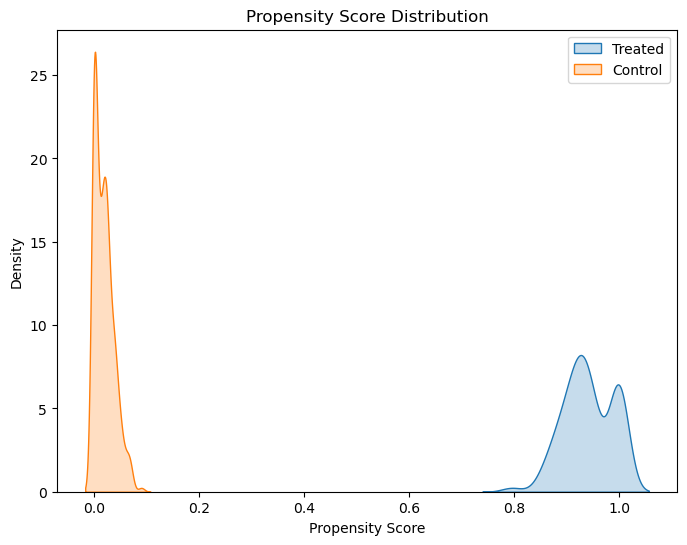

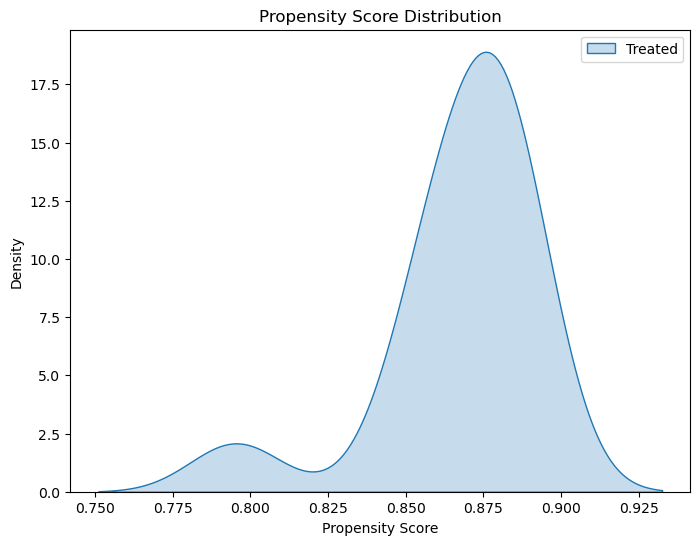

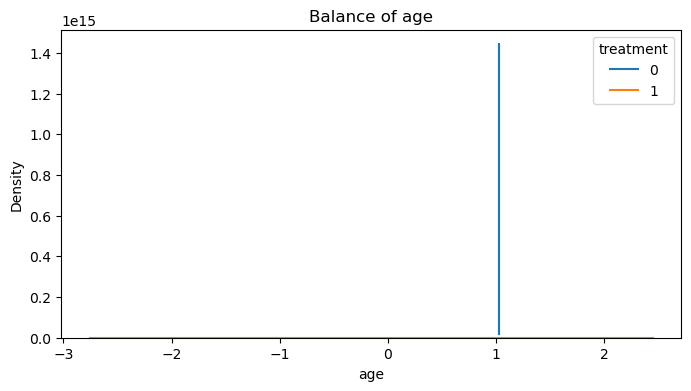

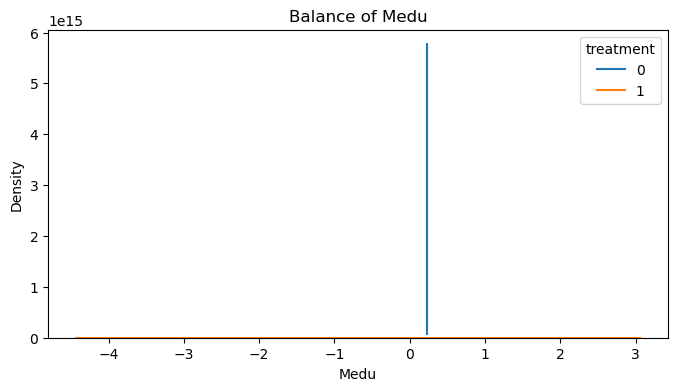

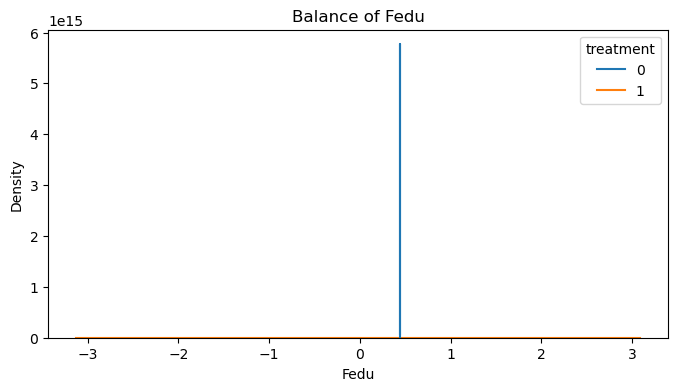

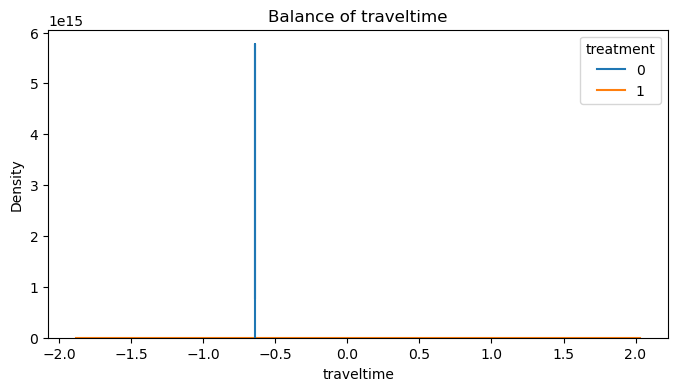

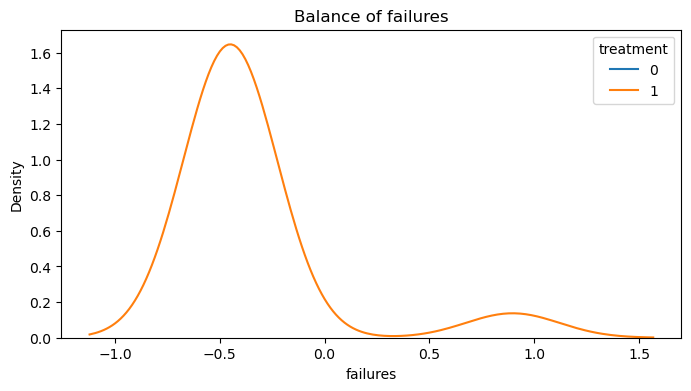

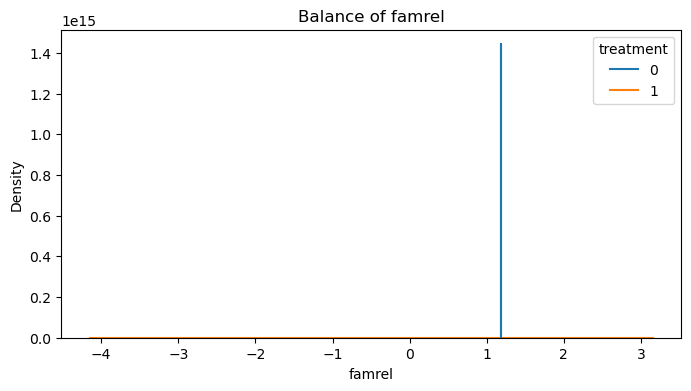

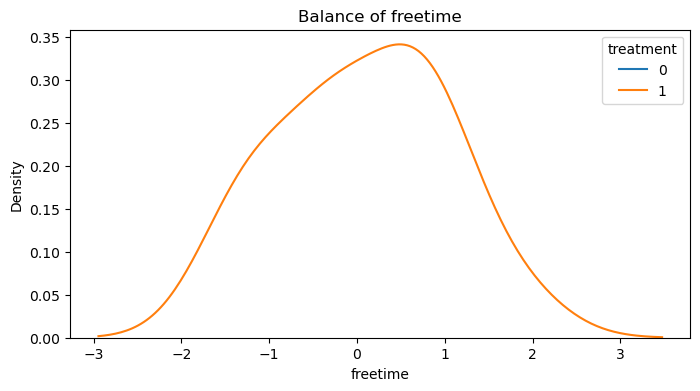

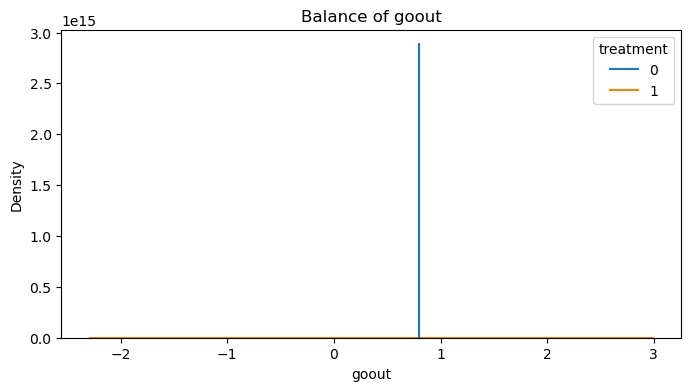

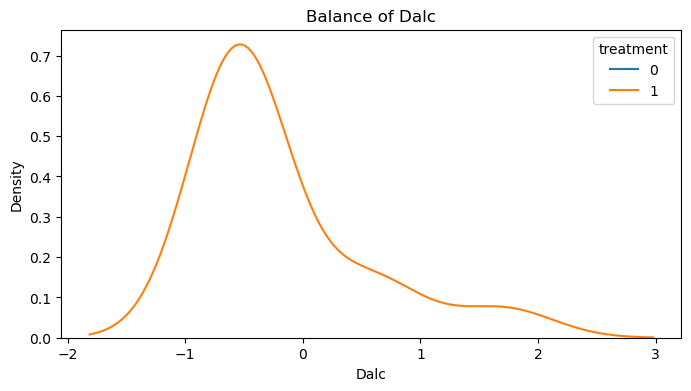

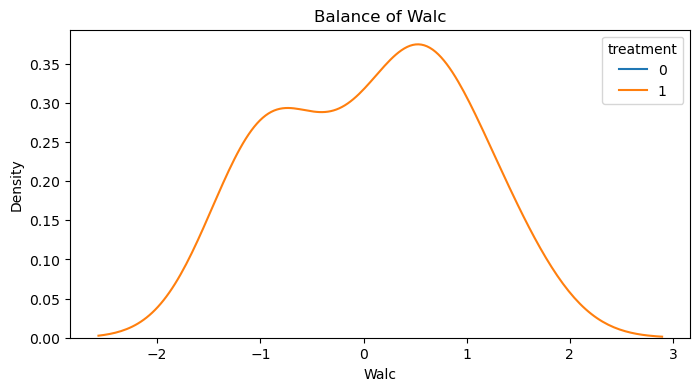

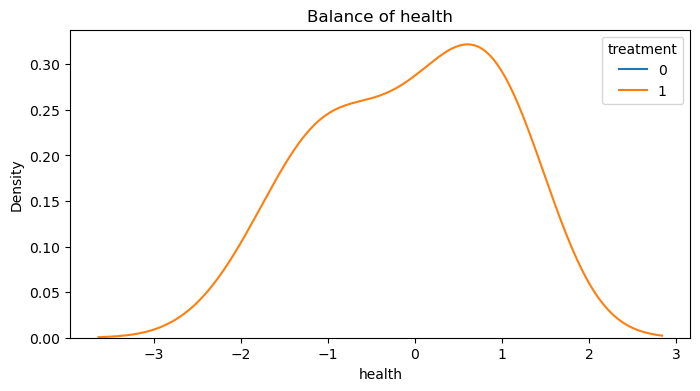

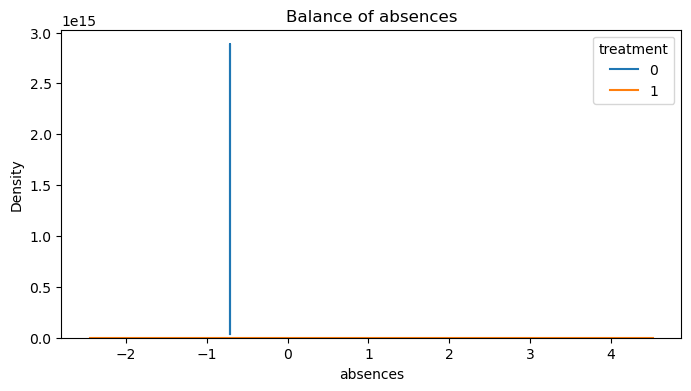

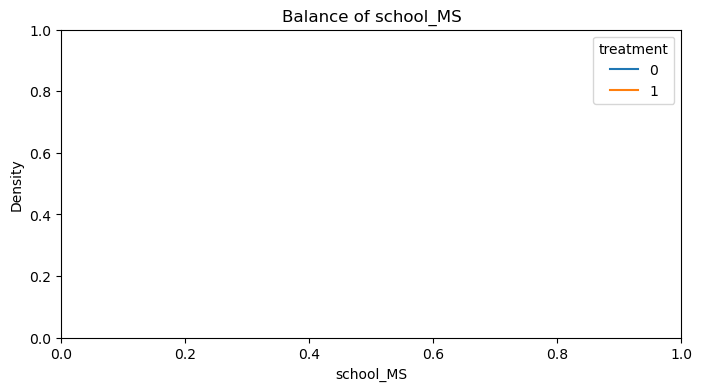

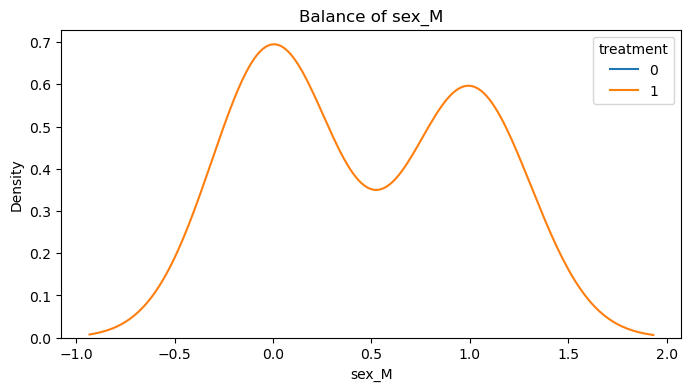

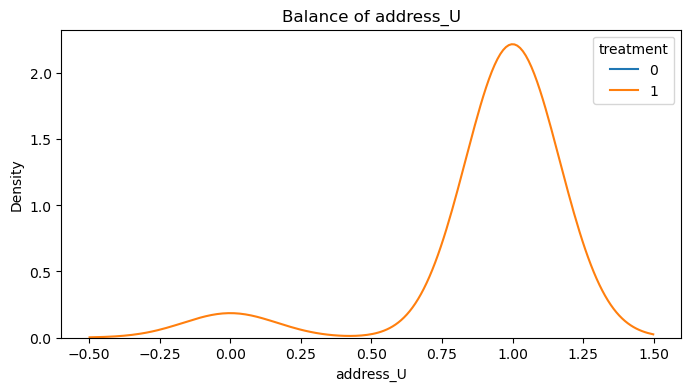

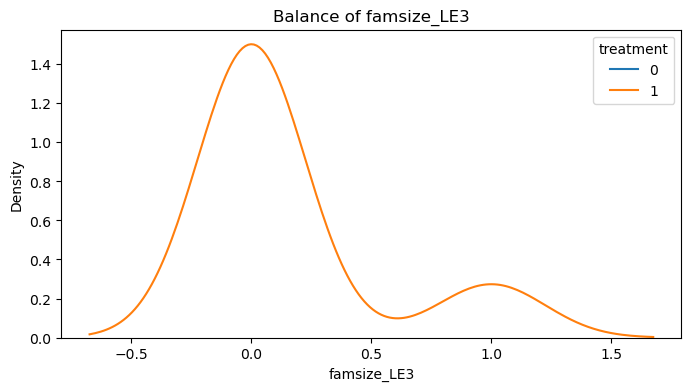

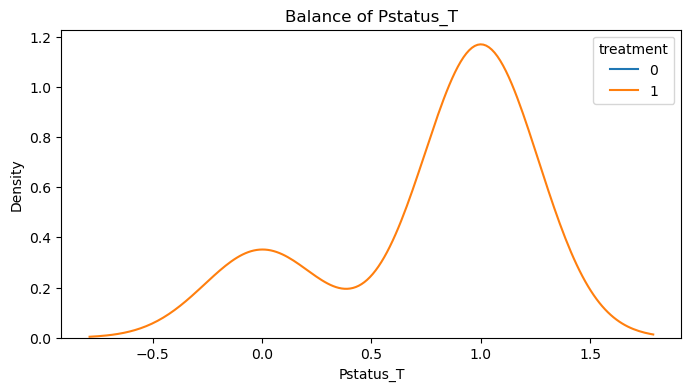

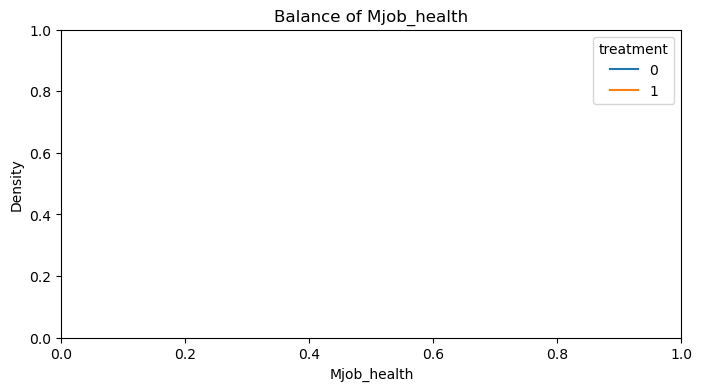

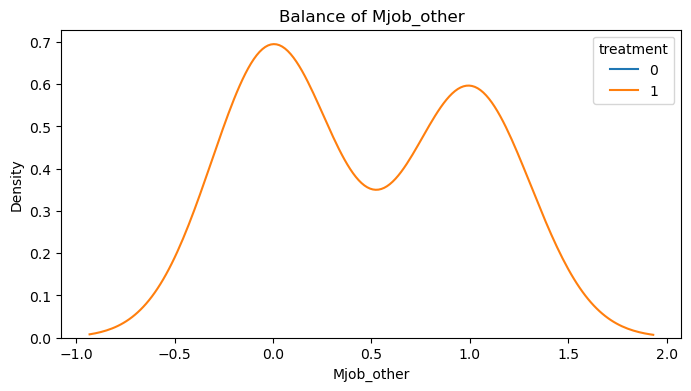

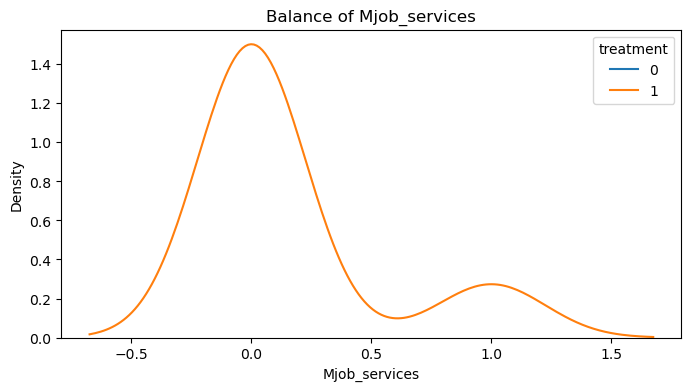

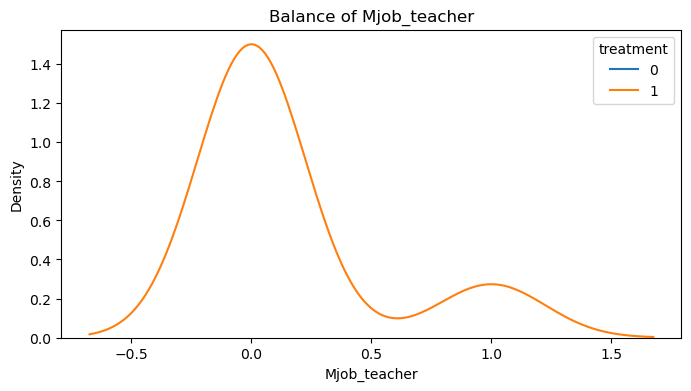

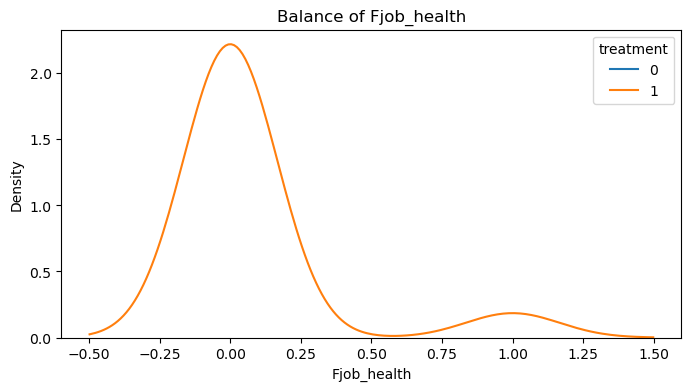

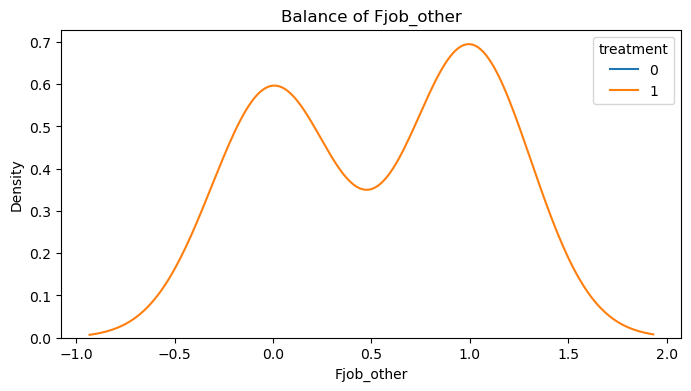

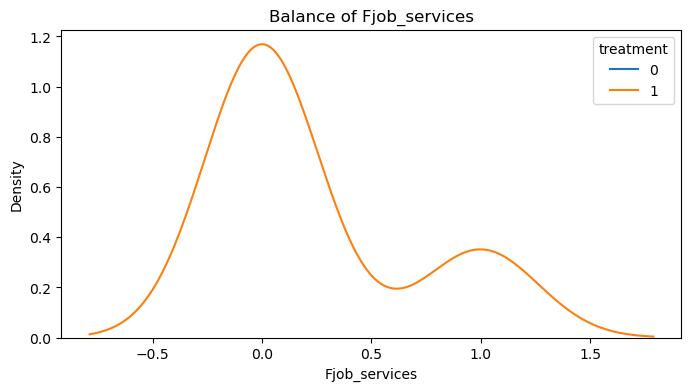

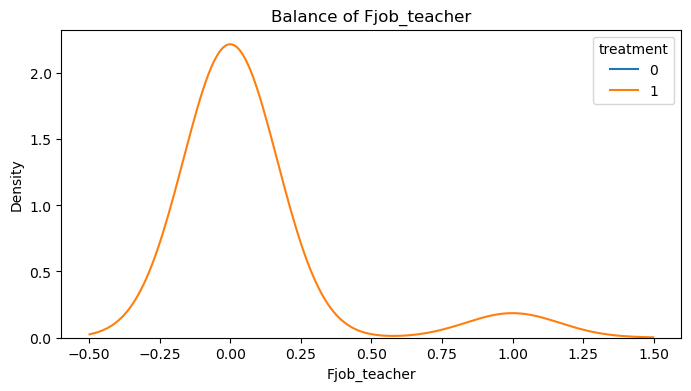

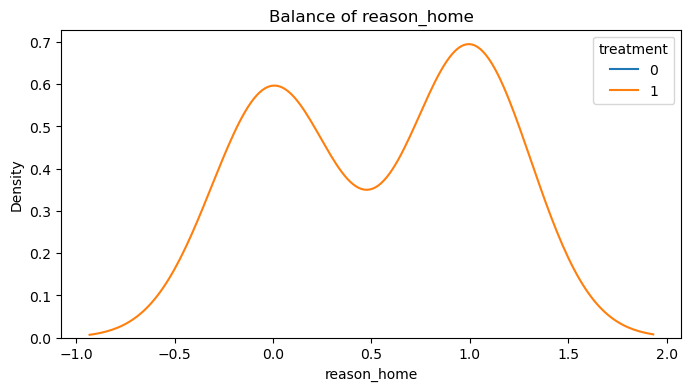

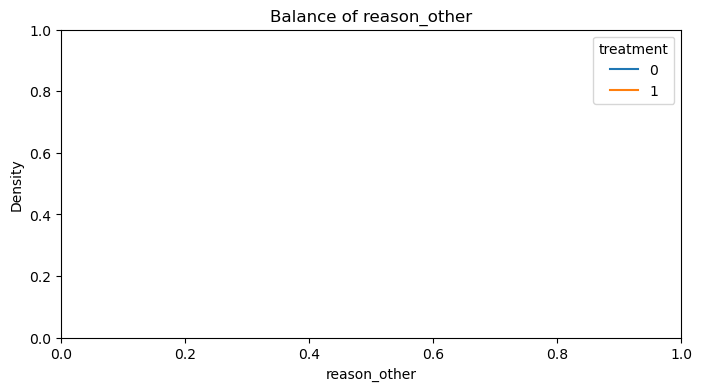

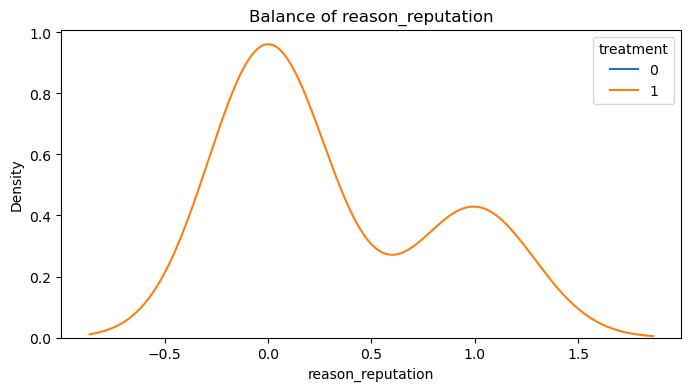

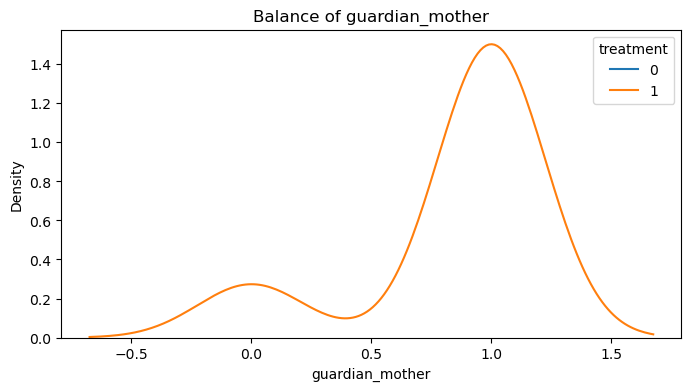

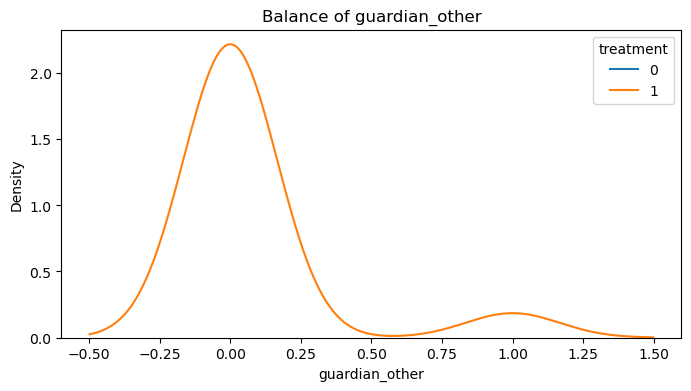

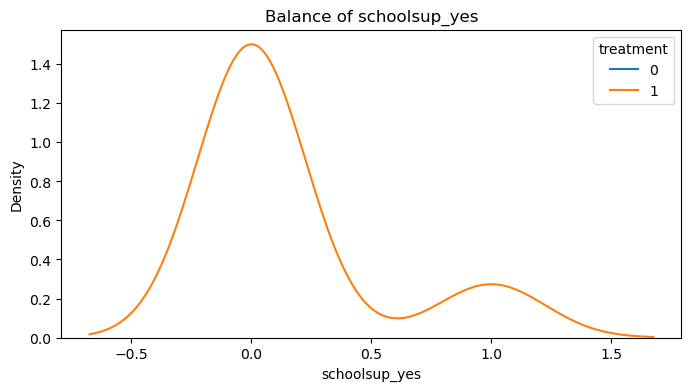

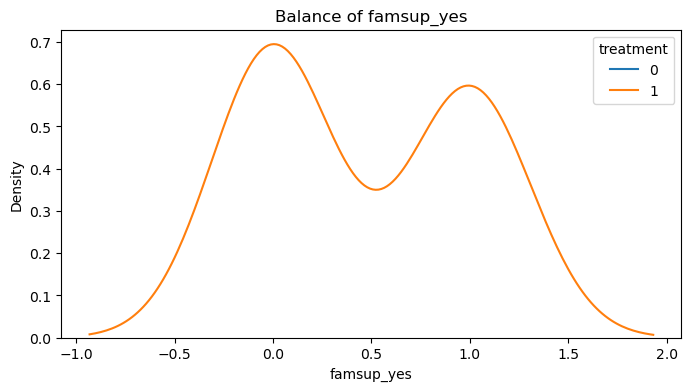

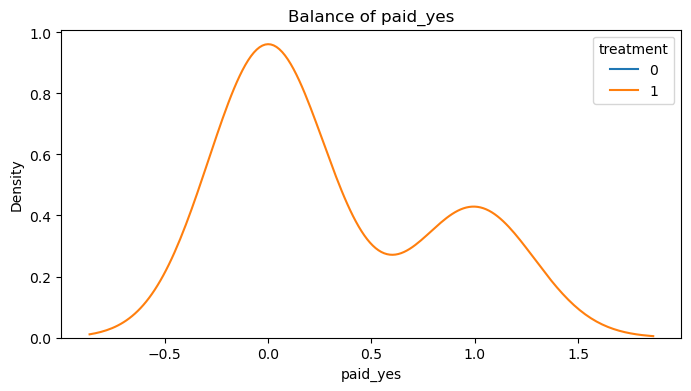

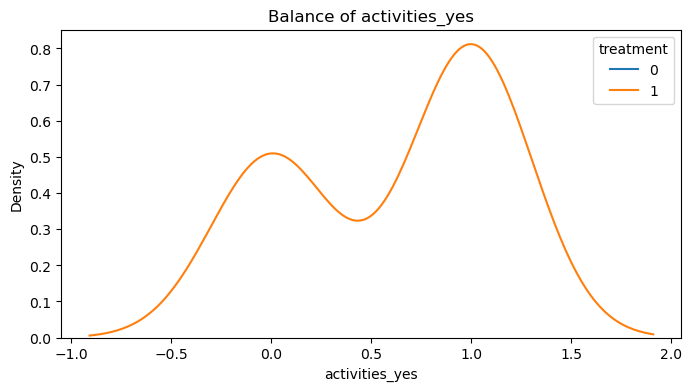

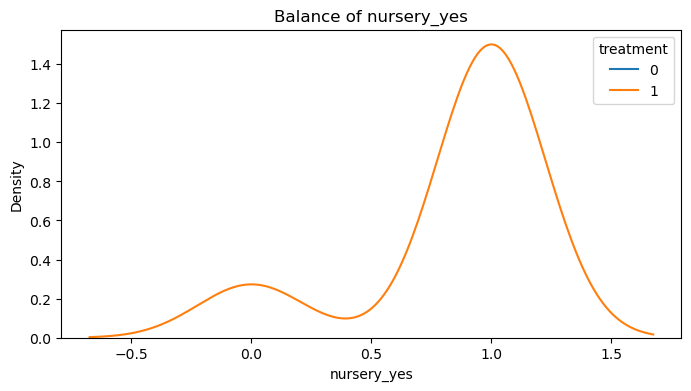

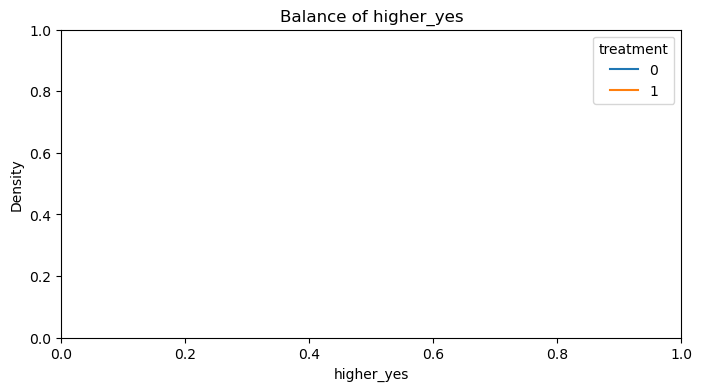

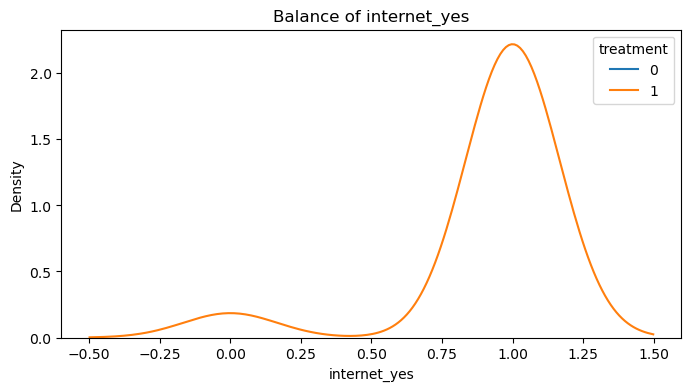

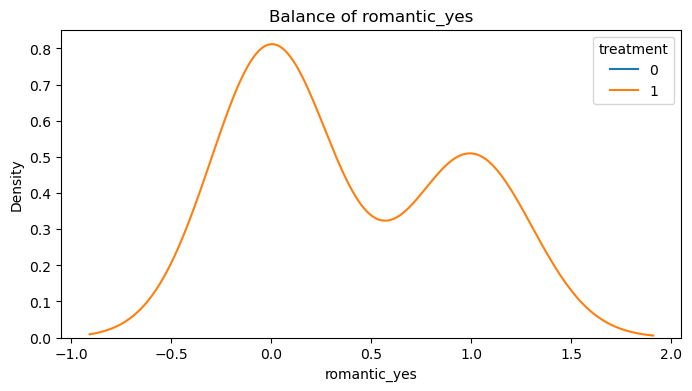

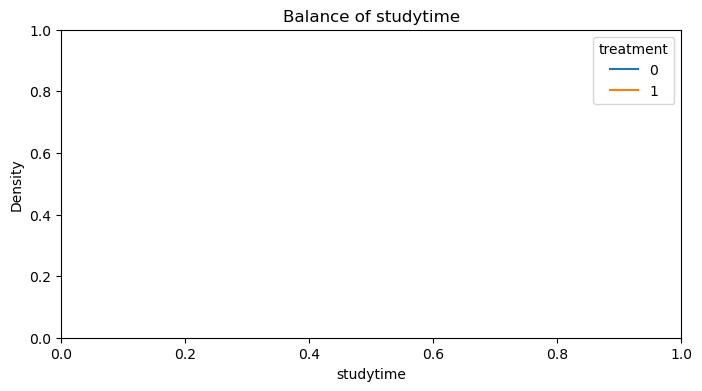

Estimated Average Treatment Effect on the Treated (ATT): 12.85


In [7]:
def PSM_causal_inference(filepath, treatment_def_func=define_treatment):
    """
    Run the PSM causal inference workflow with customizable treatment definition and matching methods.
    
    Parameters:
        filepath (str): The path to the CSV file.
        treatment_def_func (function): Function to define the treatment variable.
    
    Returns:
        None
    """
    # Load data
    df = load_data(filepath)
    
    # Preprocess data
    df_processed = preprocess_data(df)

    # Define treatment using the provided treatment definition function
    df_processed = treatment_def_func(df_processed)
    # Define feature columns (excluding treatment and outcome)
    feature_cols = df_processed.columns.drop(['treatment', 'G3']).tolist()
    
    # Calculate propensity scores
    propensity_scores, model = calculate_propensity_scores(df_processed, feature_cols)
    df_processed['propensity_score'] = propensity_scores
    
    # Visualize propensity scores before matching
    visualize_propensity_scores(df_processed, propensity_scores)
   
    # Add propensity scores to dataframe
    # Perform matching
    matched_df = perform_matching(df_processed, propensity_scores)

    # Visualize propensity scores after matching
    visualize_propensity_scores(matched_df, matched_df['propensity_score'])
    
    # Assess balance
    assess_balance(matched_df, feature_cols)
    
    # Estimate causal effect
    att = estimate_effect(matched_df)
    print(f'Estimated Average Treatment Effect on the Treated (ATT): {att:.2f}')

# Execute the main function
if __name__ == "__main__":
    filepath = 'student_data.csv'
    PSM_causal_inference(filepath)